In [ ]:
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AngleAxis,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PiecewisePose,
    Quaternion,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    TrajectorySource,
)

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario

if running_as_notebook:
    mpld3.enable_notebook()

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://e08b6c7d-dbbd-48b4-b1e2-9dcc69e260c1.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


<h1 style="font-size: 50px; color: rgb(0, 180, 140)">Pick And Place</h1>
<div style="margin-top: 25px"></div>
<p>Move the object to the desired position.</p>

<h1 style="color: rgb(255, 80, 80)">Make Gripper Frames</h1>

<p>The first step to command our robot is to make its trajectory, and the first step on making its trajectory is defining the gripper frames and the times it should reach them.</p>

<p>From starting gripper and object poses, and the desired object pose, compute every pose along the trajectory using spatial algebra. The main poses are prepick, pick, clearance, preplace, and place. </p>

<p>Other poses are added later such as pick_end and postpick that are copies of other gripper poses and are just there to accomodate for grasping times in the trajectory. (i.e. if we want the gripper to stay in place while the fingers close upon the object for 2 seconds then we need two times with the same end-effector pose, t and t + 2)</p>

<p>The times are computed as a simple linear interpolation between any two poses in the trajectory, except for simpler transitions such as opening and closing the fingers where the end-effector stays in place or moving from prepick to pick, for those there is a fixed 2 second interval.</p>

In [ ]:
def MakeGripperFrames(X_G, X_O):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and
    X_0["goal"], and returns a X_G and times with all of the pick and place
    frames populated.
    """
    # Define (again) the gripper pose relative to the object when in grasp.
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(
        np.pi / 2.0
    ) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

    X_G["pick"] = X_O["initial"] @ X_OGgrasp
    X_G["prepick"] = X_G["pick"] @ X_GgraspGpregrasp
    X_G["place"] = X_O["goal"] @ X_OGgrasp
    X_G["preplace"] = X_G["place"] @ X_GgraspGpregrasp

    # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
    X_GprepickGpreplace = X_G["prepick"].inverse() @ X_G["preplace"]
    angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    X_GprepickGclearance = RigidTransform(
        AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
        X_GprepickGpreplace.translation() / 2.0 + np.array([0, -0.3, 0]),
    )
    X_G["clearance"] = X_G["prepick"] @ X_GprepickGclearance

    # Now let's set the timing
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse() @ X_G["prepick"]
    times["prepick"] = times["initial"] + 10.0 * np.linalg.norm(
        X_GinitialGprepick.translation()
    )
    # Allow some time for the gripper to close.
    times["pick_start"] = times["prepick"] + 2.0
    times["pick_end"] = times["pick_start"] + 2.0
    X_G["pick_start"] = X_G["pick"]
    X_G["pick_end"] = X_G["pick"]
    times["postpick"] = times["pick_end"] + 2.0
    X_G["postpick"] = X_G["prepick"]
    time_to_from_clearance = 10.0 * np.linalg.norm(
        X_GprepickGclearance.translation()
    )
    times["clearance"] = times["postpick"] + time_to_from_clearance
    times["preplace"] = times["clearance"] + time_to_from_clearance
    times["place_start"] = times["preplace"] + 2.0
    times["place_end"] = times["place_start"] + 2.0
    X_G["place_start"] = X_G["place"]
    X_G["place_end"] = X_G["place"]
    times["postplace"] = times["place_end"] + 2.0
    X_G["postplace"] = X_G["preplace"]

    return X_G, times


<h1 style="color: rgb(255, 80, 80)">Build End-Effector Trajectory</h1>

<p>Using the times and poses generated in the previous step, build the trajectory using the PiecewisePose class. Remember this is a wrapper class for PiecewisePolynomial, a spline representation of translation, and PiecewiseQuaternionSlerp whcih interpolates the rotational part of the trajectory.</p>

In [ ]:
def MakeGripperPoseTrajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    sample_times = []
    poses = []
    for name in [
        "initial",
        "prepick",
        "pick_start",
        "pick_end",
        "postpick",
        "clearance",
        "preplace",
        "place_start",
        "place_end",
        "postplace",
    ]:
        sample_times.append(times[name])
        poses.append(X_G[name])

    return PiecewisePose.MakeLinear(sample_times, poses)

<h1 style="color: rgb(255, 80, 80)">Build Finger Trajectory</h1>

<p>Tell the gripper when it should be closed or opened along the trajectory.

For this we use first-order-hold, which is just linear interpolation, which means that between opened and closed states the gripper will be in a half open configuration, which is why we have a few extra opened and closed commands from what would be intuitive. I think.</p>

In [ ]:
def MakeGripperCommandTrajectory(times):
    opened = np.array([0.107])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]],
        np.hstack([[opened], [opened]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)

    return traj_wsg_command


<h1 style="color: rgb(255, 80, 80)">The Pseudo-Inverse Controller</h1>

<p>Now we need a slightly modified version of our Jacobian controller, which can take the spatial velocity commands from an input port. </p>


In [ ]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa.position", 7)
        self.DeclareVectorOutputPort("iiwa_velocity", 7, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kV,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )
        J_G = J_G[:, self.iiwa_start : self.iiwa_end + 1]  # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

<h1 style="color: rgb(255, 80, 80)">Putting It All Together</h1>

Let's put our grasping trajectories together with our Jacobian-based controller.

The first thing you might have noticed is that the Jacobian controller takes spatial velocities as input.  But so far we have trajectories for positions and orientations. Below, we differentiate them to get the velocities before we wire-up the system diagram.

Oh, boy.  Big moment.  I'm excited... are you?  Let's do this thing!

In [ ]:
meshcat.Delete()
builder = DiagramBuilder()

scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))

#Set object's initial pose to X_O["initial"] in the physics engine
X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi / 2.0), [0, -0.6, 0.0]
    ),
    "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0.5, 0, 0.0]),
}
plant = station.GetSubsystemByName("plant")
plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link"), X_O["initial"])

# Find the initial pose of the gripper (as set in the default Context)
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {
    "initial": plant.EvalBodyPoseInWorld(
        temp_plant_context, plant.GetBodyByName("body")
    )
}

#Make frames
X_G, times = MakeGripperFrames(X_G, X_O)
print(
    f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute."
)

# Make end-effector trajectory
traj = MakeGripperPoseTrajectory(X_G, times)
traj_p_G = traj.get_position_trajectory()

#Differentiate Trajectory
traj_V_G = traj.MakeDerivative()

#Define system diagram with the derivative of the trajectory as source,
#then the pseudo inverse controller, then the integrator, and 
#finally the hardware station
V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
V_G_source.set_name("v_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(V_G_source.get_output_port(), controller.GetInputPort("V_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), integrator.get_input_port())
builder.Connect(
    integrator.get_output_port(), station.GetInputPort("iiwa.position")
)
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    controller.GetInputPort("iiwa.position"),
)

#Make finger trajectory
traj_wsg_command = MakeGripperCommandTrajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg.command")
builder.Connect(
    wsg_source.get_output_port(), station.GetInputPort("wsg.position")
)

#Build the diagram
diagram = builder.Build()
diagram.set_name("pick_and_place")

#Define simulation
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)

#Start simulation
diagram.ForcedPublish(context)
meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
meshcat.PublishRecording()


INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/90397c33cab9b7234d94c1018f2755bb9989c5a8.tar.gz
Sanity check: The entire maneuver will take 26.826891105934223 seconds to execute.


<h1 style="color: rgb(255, 80, 80)">Final Pose: Desired Vs Measured</h1>

Checking measured final gripper pose vs defined "preplace" frame.
There is a bit of error in the x, y, and z axes though quite small (~10^-4).

In [ ]:
wsg = plant.GetModelInstanceByName("wsg")
gripper = plant.GetBodyByName("body",wsg)

plant_context = plant.GetMyContextFromRoot(context)

X_G_final = plant.EvalBodyPoseInWorld(plant_context, gripper)
print(X_G_final)
print(X_G["preplace"])

RigidTransform(
  R=RotationMatrix([
    [0.000413811036886261, 0.0002830477563862342, -0.9999998743221893],
    [0.9999998259498626, -0.00042066520729283993, 0.00041369194851146777],
    [-0.00042054805984724676, -0.9999998714623676, -0.00028322178302742584],
  ]),
  p=[0.5004806522586605, 0.0006197425680942862, 0.19986300395292453],
)
RigidTransform(
  R=RotationMatrix([
    [6.123233995736766e-17, -6.123233995736766e-17, -1.0],
    [1.0, 3.749399456654644e-33, 6.123233995736766e-17],
    [0.0, -1.0, 6.123233995736766e-17],
  ]),
  p=[0.5, -7.498798913309287e-34, 0.2],
)


<h1 style="color: rgb(255, 80, 80)">The System Diagram</h1>

That's quite some diagram we've assembled.  Do you understand all of the parts?

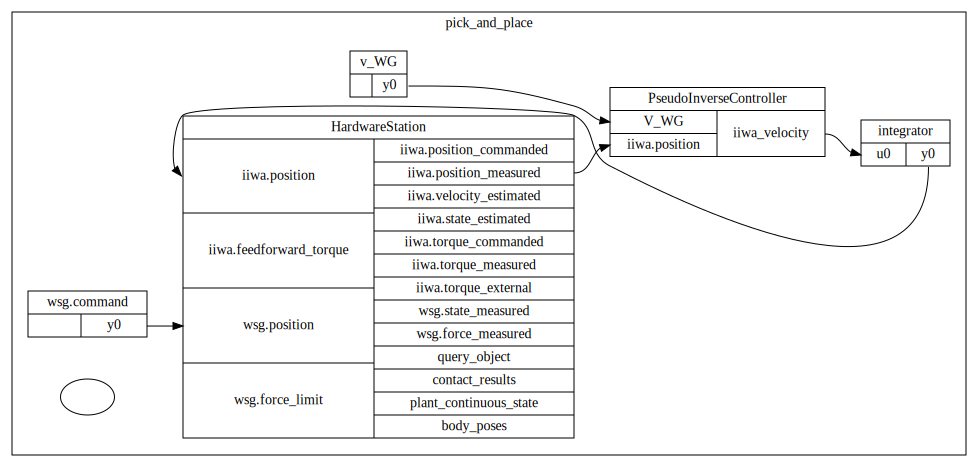

In [ ]:
SVG(
    pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[
        0
    ].create_svg()
)

<h1 style="font-size: 50px; color: rgb(0, 180, 140)">There And Back Again</h1>
<div style="margin-top: 25px"></div>
<p>Above we have our entire pick and place pipeline. Everything we need in the diagram: Our keyframes, the trajectory, its derivative, our pseudo-inverse controller, the integrator, and the hardware station with the iiwa's low level position control, the physics engine, and the geometry engine. 

Just for fun, let's see if we can revert the trajectory. That is, move the object to the desired position and then bring it back to its initial position (i.e. pick and place and then pick and place in reverse).</p>

<h1 style="color: rgb(255, 80, 80)">Make Gripper Frames</h1>

<p>Same as in pick and place but now adding the same frames from the original trajectory in reverse and their respective times. </p>

In [ ]:
#Make gripper frames but trying to make the iiwa go back and forth in the original trajectory.

def MakeGripperFrames(X_G, X_O):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and
    X_0["goal"], and returns a X_G and times with all of the pick and place
    frames populated.
    """
    # Define (again) the gripper pose relative to the object when in grasp.
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(
        np.pi / 2.0
    ) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

    X_G["pick"] = X_O["initial"] @ X_OGgrasp
    X_G["prepick"] = X_G["pick"] @ X_GgraspGpregrasp
    X_G["place"] = X_O["goal"] @ X_OGgrasp
    X_G["preplace"] = X_G["place"] @ X_GgraspGpregrasp

    #Clearance frame
    # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
    X_GprepickGpreplace = X_G["prepick"].inverse() @ X_G["preplace"]
    angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    X_GprepickGclearance = RigidTransform(
        AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
        X_GprepickGpreplace.translation() / 2.0 + np.array([0, -0.3, 0]),
    )
    X_G["clearance"] = X_G["prepick"] @ X_GprepickGclearance

    #Times and additional frames for forward trajectory
    X_G["pick_start"] = X_G["pick"]
    X_G["pick_end"] = X_G["pick"]
    X_G["postpick"] = X_G["prepick"]
    X_G["place_start"] = X_G["place"]
    X_G["place_end"] = X_G["place"]
    X_G["postplace"] = X_G["preplace"]

    period = 5.0
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse() @ X_G["prepick"]
    times["prepick"] = times["initial"] + period * np.linalg.norm(
        X_GinitialGprepick.translation()
    )
    times["pick_start"] = times["prepick"] + 2.0
    times["pick_end"] = times["pick_start"] + 2.0
    times["postpick"] = times["pick_end"] + 2.0
    time_to_from_clearance = period * np.linalg.norm(
        X_GprepickGclearance.translation()
    )
    times["clearance"] = times["postpick"] + time_to_from_clearance
    times["preplace"] = times["clearance"] + time_to_from_clearance
    times["place_start"] = times["preplace"] + 2.0
    times["place_end"] = times["place_start"] + 2.0
    times["postplace"] = times["place_end"] + 2.0
  
    #Frames and times for the return trajectory
    X_G["prepick2"] = X_G["preplace"] 
    X_G["pick_start2"] = X_G["place"]
    X_G["pick_end2"] = X_G["place"]
    X_G["postpick2"] = X_G["preplace"]
    X_G["clearance2"] = X_G["clearance"]
    X_G["preplace2"] = X_G["prepick"]
    X_G["place_start2"] = X_G["pick"]
    X_G["place_end2"] = X_G["pick"]
    X_G["postplace2"] = X_G["prepick"]

    times["prepick2"] = times["postplace"] + 2.0
    times["pick_start2"] = times["prepick2"] + 2.0
    times["pick_end2"] = times["pick_start2"] + 2.0
    times["postpick2"] = times["pick_end2"] + 2.0
    times["clearance2"] = times["postpick2"] + time_to_from_clearance
    times["preplace2"] = times["clearance2"] + time_to_from_clearance
    times["place_start2"] = times["preplace2"] + 2.0
    times["place_end2"] = times["place_start2"] + 2.0
    times["postplace2"] = times["place_end2"] + 2.0

    return X_G, times


<h1 style="color: rgb(255, 80, 80)">Build End-Effector Trajectory</h1>

In [ ]:
def MakeGripperPoseTrajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    sample_times = []
    poses = []
    for name in [
        "initial",
        "prepick",
        "pick_start",
        "pick_end",
        "postpick",
        "clearance",
        "preplace",
        "place_start",
        "place_end",
        "postplace",
        "prepick2", 
        "pick_start2",
        "pick_end2",
        "postpick2",
        "clearance2",
        "preplace2",
        "place_start2",
        "place_end2",
        "postplace2"        
    ]:
        sample_times.append(times[name])
        poses.append(X_G[name])

    return PiecewisePose.MakeLinear(sample_times, poses)

<h1 style="color: rgb(255, 80, 80)">Build Finger Trajectory</h1>

In [ ]:
def MakeGripperCommandTrajectory(times):
    opened = np.array([0.107])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]],
        np.hstack([[opened], [opened]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["pick_start2"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end2"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start2"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end2"], opened)

    return traj_wsg_command


<h1 style="color: rgb(255, 80, 80)">Putting It All Together</h1>

<p>Make sure you run the pseudo-inverse controller block from the Pick And Place section first.</p>

In [ ]:
meshcat.Delete()
builder = DiagramBuilder()

scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))

#Set object's initial pose to X_O["initial"] in the physics engine
X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi / 2.0), [0, -0.6, 0.0]
    ),
    "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0.5, 0, 0.0]),
}
plant = station.GetSubsystemByName("plant")
plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link"), X_O["initial"])

# Find the initial pose of the gripper (as set in the default Context)
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {
    "initial": plant.EvalBodyPoseInWorld(
        temp_plant_context, plant.GetBodyByName("body")
    )
}

#Make frames
X_G, times = MakeGripperFrames(X_G, X_O)
print(
    f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute."
)

# Make end-effector trajectory
traj = MakeGripperPoseTrajectory(X_G, times)
traj_p_G = traj.get_position_trajectory()

#Differentiate Trajectory
traj_V_G = traj.MakeDerivative()

#Define system diagram with the derivative of the trajectory as source,
#then the pseudo inverse controller, then the integrator, and 
#finally the hardware station
V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
V_G_source.set_name("v_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(V_G_source.get_output_port(), controller.GetInputPort("V_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), integrator.get_input_port())
builder.Connect(
    integrator.get_output_port(), station.GetInputPort("iiwa.position")
)
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    controller.GetInputPort("iiwa.position"),
)

#Make finger trajectory
traj_wsg_command = MakeGripperCommandTrajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg.command")
builder.Connect(
    wsg_source.get_output_port(), station.GetInputPort("wsg.position")
)

#Build the diagram
diagram = builder.Build()
diagram.set_name("pick_and_place")

#Define simulation
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)

#Start simulation
diagram.ForcedPublish(context)
meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
meshcat.PublishRecording()


Sanity check: The entire maneuver will take 19.413445552967108 seconds to execute.


<h1 style="color: rgb(255, 80, 80)">Final Pose: Desired Vs Measured</h1>

Just as in the pick and place scenario the error seems quite small (~10^-4).
If I increase the speed at which the arm moves (to twice as much), then the error does increase to about 10^-3.

In [ ]:
wsg = plant.GetModelInstanceByName("wsg")
gripper = plant.GetBodyByName("body",wsg)

plant_context = plant.GetMyContextFromRoot(context)

X_G_final = plant.EvalBodyPoseInWorld(plant_context, gripper)
print(X_G_final)
print(X_G["preplace2"])

RigidTransform(
  R=RotationMatrix([
    [0.9999995531883878, -0.0007413454403798625, -0.0005865406751701726],
    [0.0005866453217923335, 0.00014094813638889687, 0.9999998179904286],
    [-0.0007412626336329437, -0.9999997152702402, 0.00014138298024622976],
  ]),
  p=[-0.0016156459340884181, -0.5971629143181746, 0.19875467084943987],
)
RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 6.123233995736766e-17, 1.0],
    [0.0, -1.0, 6.123233995736766e-17],
  ]),
  p=[0.0, -0.6, 0.2],
)


That's all folks!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e08b6c7d-dbbd-48b4-b1e2-9dcc69e260c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>